In [2]:
import json
import os
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Poisson
import statsmodels.api as sm
import pytest
from statsmodels.stats.diagnostic import het_white
import scipy.stats as stats

In [3]:
suffix = ''
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests', suffix)
retrieved_data =  []
names = []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
        names.append(file.split('.')[0].split('q')[1])
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqaiMotive.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqAParametricTopViewRepresentationofComplexRoadScenes.json
Added  reqApolloScape.json
Added  reqArgoverse1Stereo.json
Added  reqArgoverse2Lidar.json
Added  reqArgoverse2MapChange.json
Added  reqArgoverse2MotionForecasting.json
Added  reqArgoverse2Sensor.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqAutomatumOpenHighway.json
Added  reqAutonomousPlatformInertial.json
Added  reqBayArea.json
Added  reqBDD100k.json
Added  reqBDD100KAPS.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxCars116k.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqC

In [4]:
print(len(names))
df_name = pd.DataFrame(names)
df_name.to_csv(f'output/retrieved_{len(names)}.csv', index=False, header=False, sep=",")

205


In [5]:
def calc_h_score(citations):
    """Calculates h-index"""
    if citations:
        citations = np.array(citations)
        n         = citations.shape[0]
        array     = np.arange(1, n+1)
        # reverse sorting
        citations = np.sort(citations)[::-1]
        # intersection of citations and k
        h_idx = np.max(np.minimum(citations, array))
        return h_idx
    else:
        return 0

In [6]:
class scoring:
    """For calculating h-indexes and absolut counts of citation-based features"""
    def __init__(self, o_paper, lower_bound, upper_bound, impact_year):
        self.o_paper = o_paper
        self.lower_bound = o_paper['paperInfo']['year'] - lower_bound # years prior to the publication used for calculating various scores
        self.upper_bound = o_paper['paperInfo']['year'] + upper_bound # year after publication used for calculating various scores
        self.impact_year = o_paper['paperInfo']['year'] + impact_year # year(s) after publication when we want to know a papers impact

    def number_citations_authors(self, author):
        """Returns a list where each entry is the number of citations a paper by a given author had up until the given year. Ignores citations without year resulting in different counts compared to the one given by the API."""
        ls_citations = []
        for paper in self.o_paper['paperInfo']['authors'][author]['authorsPapers']:
            #print(paper)
            if 'year' in paper and paper['year'] is not None and paper['year'] <= self.upper_bound:
                numb_cit = 0
                for citation in paper['citations']:
                    if 'year' in citation and citation['year'] is not None and self.upper_bound >= citation[
                        'year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def number_citations_ref(self, dimension='references', dimension_papers='citations'):
        """Like number_citations but the list elements represent the citations the references/citations of a paper received."""
        ls_citations = []
        for paper in self.o_paper['paperInfo'][dimension]:
            if paper['year'] is not None and paper['year'] <= self.upper_bound and 'citations' in paper.keys():
                numb_cit = 0
                for citation in paper[dimension_papers]:
                    if citation['year'] is not None and self.upper_bound >= citation['year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def just_citations(self):
        """Citation count of a paper prior to impact year and after lower bound"""
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            if paper['year'] is not None and self.impact_year >= paper['year'] >= self.lower_bound:
                        numb_cit += 1
        return numb_cit

    def just_citations_non_cumulative(self):
        """Returns citation count for only a year instead of cumulatively"""
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            #print(paper)
            if paper['year'] is not None and self.impact_year == paper['year']:
                        numb_cit += 1
                        #print((paper['year'] + self.impact_year))
        return numb_cit
    def reference_score(self):
        return calc_h_score(self.number_citations_ref())
    def citations_citations_score(self):
        return calc_h_score(self.number_citations_ref('citations', 'citations'))
    def citations_citations_sum(self):
        return np.sum(self.number_citations_ref('citations', 'citations'))
    def citations_single_author_score(self, author_number):
        return calc_h_score(self.number_citations_authors(author_number))


In [7]:
impact_year = 9
ind_paper = 0
print(retrieved_data[ind_paper]['id'])
scorer = scoring(retrieved_data[ind_paper], 200, 0, impact_year)
print(impact_year, retrieved_data[ind_paper]['paperInfo']['year']+impact_year, scorer.just_citations_non_cumulative())

KITTI
9 2022 1027


When do citations take off

In [8]:
def citation_timeline_array(retrieved_data):
    """Columns are years, rows datasets. column 0 is year prior to publication. column 1 year of pub. etc. entries are #citations that year"""
    array = np.zeros([len(retrieved_data), 16])
    names = []
    for paper_idx, paper in enumerate(tqdm(retrieved_data)): #iterate over all papers
        names.append(paper['id'])
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys(): #check if paper has info on year
            array_idx = 0
            for impact_year in range(-1, 2022-retrieved_data[paper_idx]['paperInfo']['year']+1, 1):
                # iterates from 1 year prior to publication until today. e.g. kitti pub in 2012 2011-2022 -> last entry column 9
                scorer = scoring(paper, 200, 0, impact_year)
                array[paper_idx][array_idx] = scorer.just_citations() #calulate citation count of paper
                array_idx += 1
    return array, names
array, name = citation_timeline_array(retrieved_data)
array

100%|██████████| 205/205 [00:00<00:00, 1785.56it/s]


array([[  1.,   7.,  90., ...,   0.,   0.,   0.],
       [  0.,   1.,  10., ...,   0.,   0.,   0.],
       [  5.,  97., 480., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   5., ...,   0.,   0.,   0.],
       [  0.,   3.,   9., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [9]:
#select three first years (approx. 50 papers haven't been out for 3 years so we loose them)
data = array
data = np.delete(data, np.s_[-12:], axis=1)
df = pd.DataFrame(data).set_axis(name)#
for column in range(df.shape[1]):
    if column >= 3:
        df = df[df[column] > 0]
data = np.array(df)

Plot time-line of the citation count of all papers

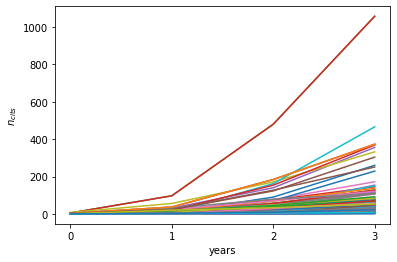

In [10]:
df_transpose = df.transpose()
df_transpose.plot()
plt.legend().remove()
plt.xlabel('years')
plt.ylabel('$n_{cits}$')
plt.xticks([*range(4)], [*range(4)])
plt.savefig('output/citations_over_time.pdf')
plt.show()
#df_transpose

In [11]:
df_transpose

,KITTI,Cars,nuImages,nuScenes,Synthia,GTA5,Caltech Pedestrian,CamVid,Oxford Robot Car,Waymo Open Perception,...,IDDA,MuIRan,PIE,RUGD: Robot Unstructured Ground Driving,SeeingThroughFog,SemKITTI-DVPS,Synthetic Discrepancy,TITAN,USyd Campus,UTBM EU LTD
0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,1.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7.0,1.0,97.0,97.0,31.0,23.0,11.0,6.0,56.0,9.0,...,0.0,17.0,0.0,0.0,2.0,2.0,5.0,20.0,1.0,3.0
2,90.0,10.0,480.0,480.0,140.0,123.0,77.0,17.0,171.0,162.0,...,5.0,45.0,28.0,2.0,7.0,29.0,12.0,33.0,5.0,9.0
3,260.0,34.0,1058.0,1058.0,356.0,304.0,172.0,32.0,332.0,466.0,...,20.0,92.0,70.0,24.0,46.0,58.0,31.0,54.0,8.0,22.0


Identify how many clusters are appropriate through an elbow plot

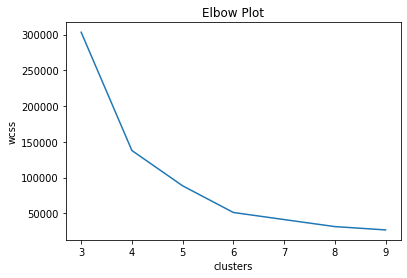

In [12]:
wcss = []
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
plt.plot([*range(3, 10)], wcss)
plt.title('Elbow Plot')
plt.xlabel('clusters')
plt.ylabel('wcss')
plt.show()

Slect the last bend at 6 clusters. (Compared to 4 clusters, the bottom cluster is split in two, which makes a difference in year 3)

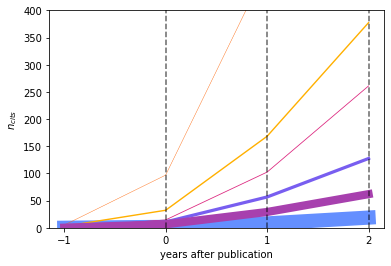

In [13]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data)
clusters = kmeans.cluster_centers_
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE']
labels = pd.Series(kmeans.labels_)
labels = labels.value_counts(ascending=True).sort_index()
for label, cluster in enumerate(clusters):
    plt.plot([*range(-1, cluster.shape[0]-1)], cluster, alpha=1, label=label, color=colors[label] ,lw=labels.iloc[label]/5)
    #print(labels.iloc[label])
y_lim = 400
plt.ylim(0, y_lim)
plt.vlines(0, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)

#plt.hlines(100, 0, 4, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(-1, cluster.shape[0]-1)])
plt.xlabel('years after publication')
plt.ylabel('$n_{cits}$')
plt.savefig('output/citations_clustering.pdf', bbox_inches='tight')
plt.show()

In [14]:
# paper from 2020: -1=2019, 0=2020, 1=2021 2=2022

In [15]:
for clu in clusters:
    print(clu)

[ 0.07042254  1.67605634  8.02816901 18.78873239]
[   5.   97.  480. 1058.]
[  1.   14.5 102.5 261. ]
[  2.71428571  32.28571429 168.42857143 377.42857143]
[  0.4375  10.8125  56.6875 127.5   ]
[ 0.2195122   6.46341463 29.09756098 61.92682927]


In [16]:
labels = pd.Series(kmeans.labels_)
labels.value_counts(ascending=True)

1     2
2     4
3     7
4    16
5    41
0    71
dtype: int64

In [17]:
def create_modelling_df_altmetric_sensor(retrieved_data, lower_bound, upper_bound, impact_year):
    """creates df for regression from retrieved data with sensor & altmetric. lower bound and upper bound give the respective first and last year for calulcating scores. Impact year the year for which the citation count should be calculated"""
    array = np.zeros([len(retrieved_data), 4])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = np.mean(ls_author_scores[:])
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:4] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score] #, first_author_score
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    similar_age_3m = []
    row_w_missing_data = []
    missing_altmetirc_counter = 0
    missing_frame_counter = 0
    missing_sensor_counter = 0

    culprit_sensor = 0
    culprit_frames = 0
    culprit_altmetrics = 0
    for idx_paper, paper in enumerate(retrieved_data):
        missing_altmetirc_flag = False
        missing_frame_flag = False
        missing_sensor_flag = False
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            similar_age_3m_value = float(paper['altmetrics'][2]['similar_age_3m_percentile']['percentile'])
        except:
            row_w_missing_data.append(idx_paper)
            missing_altmetirc_counter += 1
            missing_altmetirc_flag = True
            #similar_age_3m_value = float('NaN')
        try:
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                missing_frame_counter += 1
                missing_frame_flag = True
                #frames_value = float('NaN')
        except:
            row_w_missing_data.append(idx_paper)
            missing_frame_counter += 1
            missing_frame_flag = True
            #frames_value = float('NaN')
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
        except:
            row_w_missing_data.append(idx_paper)
            missing_sensor_counter += 1
            missing_sensor_flag = True
            sensors_value = float('NaN')

        if not (missing_sensor_flag or missing_frame_flag or missing_altmetirc_flag):
            frames.append(frames_value)
            sensors.append(sensors_value)
            similar_age_3m.append(similar_age_3m_value)

        if missing_altmetirc_flag and not missing_sensor_flag and not missing_frame_flag:
            culprit_altmetrics += 1
        if  missing_sensor_flag and not missing_frame_flag and not missing_altmetirc_flag:
            culprit_sensor += 1
        if missing_frame_flag and not missing_sensor_flag and not missing_altmetirc_flag:
            culprit_frames += 1

    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[list(set(row_w_missing_data))])
    print("Missing Data (due to missing features):", len(row_w_missing_data))
    df['sensors'] = sensors
    df['frames'] = frames
    df['similar_age_3m_percentile'] = similar_age_3m
    cols = list(df.columns)
    cols[:4] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score'] #, 'first_author_score'
    df.columns = cols

    before = df.shape[0]
    df = df[df.year <= (2022-impact_year)]
    print('Missing Data (due to year):', (before-df.shape[0]))
    print('Missing values: altmetrics:', missing_altmetirc_counter, 'frames', missing_frame_counter, 'sensors', missing_sensor_counter)
    print('missing due to (other features available) frames', culprit_frames, 'sensors', culprit_sensor, 'altmetrics', culprit_altmetrics)
    return df

In [18]:
def create_modelling_df_no_frames(retrieved_data, lower_bound, upper_bound, impact_year):
    """creates df for regression from retrieved data with sensor & altmetric. lower bound and upper bound give the respective first and last year for calulcating scores. Impact year the year for which the citation count should be calculated"""
    array = np.zeros([len(retrieved_data), 4])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = np.mean(ls_author_scores[:])
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:4] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score] #, first_author_score
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    similar_age_3m = []
    row_w_missing_data = []
    missing_altmetirc_counter = 0
    missing_sensor_counter = 0

    culprit_sensor = 0
    culprit_altmetrics = 0
    for idx_paper, paper in enumerate(retrieved_data):
        missing_altmetirc_flag = False
        missing_sensor_flag = False
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            similar_age_3m_value = float(paper['altmetrics'][2]['similar_age_3m_percentile']['percentile'])
        except:
            row_w_missing_data.append(idx_paper)
            missing_altmetirc_counter += 1
            missing_altmetirc_flag = True
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
        except:
            row_w_missing_data.append(idx_paper)
            missing_sensor_counter += 1
            missing_sensor_flag = True
            sensors_value = float('NaN')

        if not (missing_sensor_flag or missing_altmetirc_flag):
            sensors.append(sensors_value)
            similar_age_3m.append(similar_age_3m_value)

        if missing_altmetirc_flag and not missing_sensor_flag:
            culprit_altmetrics += 1
        if  missing_sensor_flag and not missing_altmetirc_flag:
            culprit_sensor += 1

    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[list(set(row_w_missing_data))])
    print("Missing Data (due to missing features):", len(row_w_missing_data))
    df['sensors'] = sensors
    df['similar_age_3m_percentile'] = similar_age_3m
    #df['similar_age_3m_percentile_square'] = df.similar_age_3m_percentile.pow(2)
    cols = list(df.columns)
    cols[:4] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score'] #, 'first_author_score'
    df.columns = cols

    before = df.shape[0]
    df = df[df.year <= (2022-impact_year)]
    print('Missing Data (due to year):', (before-df.shape[0]))
    print('Missing values: altmetrics:', missing_altmetirc_counter, 'sensors', missing_sensor_counter)
    print('missing due to (other features available): sensors', culprit_sensor, 'altmetrics', culprit_altmetrics)
    return df

In [19]:
def convert_and_plot_data(df, drop='citations_citations_c', dependent_var='citation_c'):
    """clean up wrong value and convert to log scale"""
    try:
        replacement = df.at['Street Learn', 'frames'].replace(',', '')
        #print(replacement)
        df.at['Street Learn', 'frames'] = replacement
    except:
        print('No problem w street learn')
    modelling_df = df
    # modelling_df = modelling_df.drop(['BDD100k', 'Argoverse Motion Forecasting'], axis=0)
    modelling_df = modelling_df.drop([drop], axis=1)
    for idx_column, col in enumerate(modelling_df.columns):
        modelling_df[col] = modelling_df[col].astype("float")
    for idx, variable in enumerate(modelling_df):
        plt.scatter(modelling_df[variable], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx])
        plt.show()
        #plt.hist(modelling_df[variable])
        #plt.show()
    modelling_df[dependent_var] = np.log(modelling_df[dependent_var]+1)
    if 'frames' in modelling_df.columns:
        modelling_df.frames = np.log(modelling_df.frames+1)
    return modelling_df

def normalize(modelling_df, dependent_var='citation_c'):
    """normalize df before modelling"""
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = (modelling_df[col]-modelling_df[col].mean())/(modelling_df[col].std())

    return modelling_df

def center(modelling_df, dependent_var='citation_c'):
    """normalize df before modelling"""
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = modelling_df[col]-modelling_df[col].mean()
                plt.scatter(modelling_df[col], modelling_df[dependent_var])
                plt.xlabel(list(modelling_df.columns)[idx_column])
                plt.show()
    return modelling_df
def modelling(modelling_df, dependent_var='citation_c', show_summary=False):
    """do regression with statistics"""
    for idx_column, col in enumerate(modelling_df.columns):
        plt.scatter(modelling_df[col], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx_column])
        plt.show()
    independent_vars = modelling_df.drop([dependent_var], axis=1)
    X = add_constant(independent_vars)
    y = modelling_df[dependent_var]
    mod = sm.regression.linear_model.OLS(y, independent_vars.assign(intercept=1))
    res = mod.fit(cov_type="HC1")
    if show_summary:
        print(res.summary())
    test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
    print('test', test)
    vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    print(vif)
    #perform White's test
    white_test = het_white(res.resid,  res.model.exog)

    #define labels to use for output of White's test
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

    #print results of White's test
    print(dict(zip(labels, white_test)))
    fig = sm.qqplot(res.resid, stats.t, fit=True, line='45')
    plt.title('QQ_plot')
    plt.show()
    fitted_y = res.fittedvalues
    plot = sns.residplot(x=fitted_y, y=modelling_df[dependent_var], data=modelling_df, lowess=True)
    plt.show()
    for variable in independent_vars:
        plot = sns.residplot(x=independent_vars[variable], y=modelling_df[dependent_var], data=modelling_df, lowess=True)
        plt.show()
    return res, fitted_y, y, independent_vars

wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests', suffix)
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        print(file)
        a = json.loads(j.read())
        retrieved_data.append(a)

retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

'wd = wd.replace(\'.ipynb_checkpoints\', \'\')\ndirectory = os.path.join(wd, \'data\', \'requests8\')\nretrieved_data =  []\nfor file in os.listdir(directory):\n    with open(os.path.join(directory, file), "r") as j:\n        print(file)\n        a = json.loads(j.read())\n        retrieved_data.append(a)\n\nretrieved_data = sorted(retrieved_data, key=itemgetter(\'citationCount\'), reverse=True)'

Including altmetrics leads to 159 missing observations. Including sensors if frames is included leads to no missing values.

100%|██████████| 205/205 [00:19<00:00, 10.71it/s]


Missing Data (due to missing features): 76
Missing Data (due to year): 20
Missing values: altmetrics: 66 sensors 10
missing due to (other features available): sensors 8 altmetrics 64
No problem w street learn


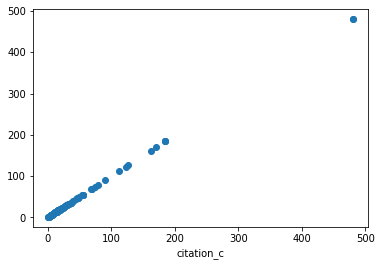

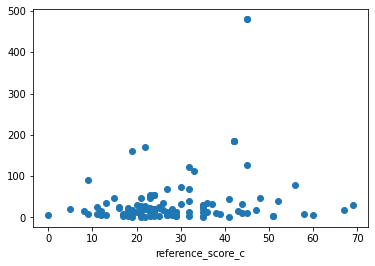

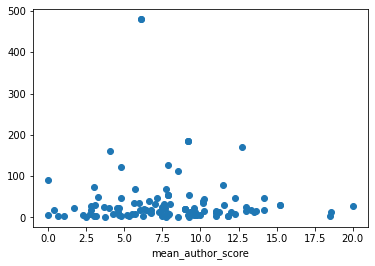

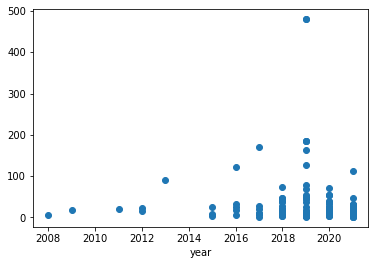

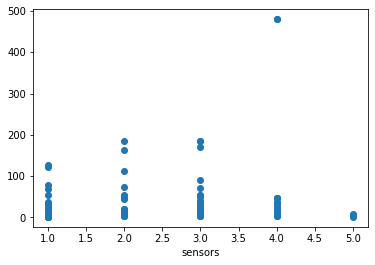

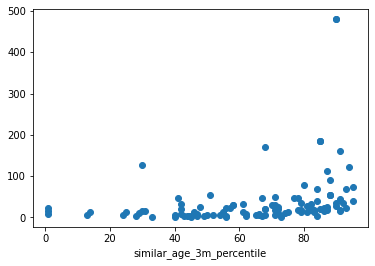

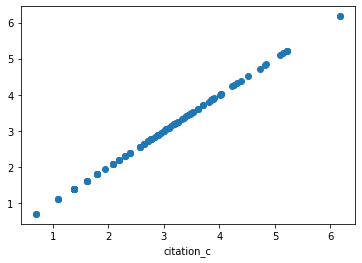

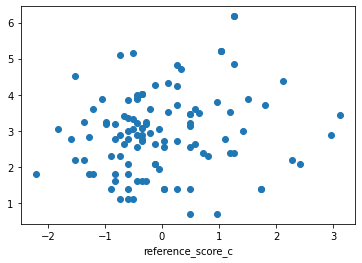

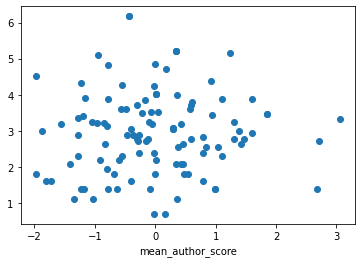

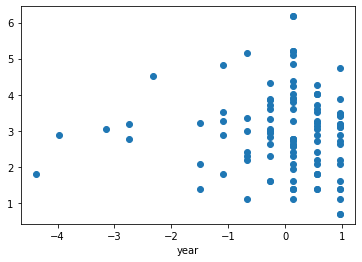

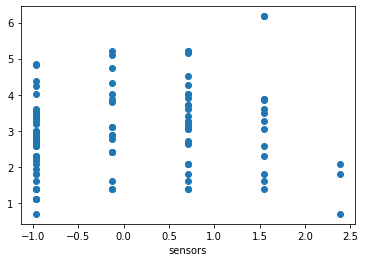

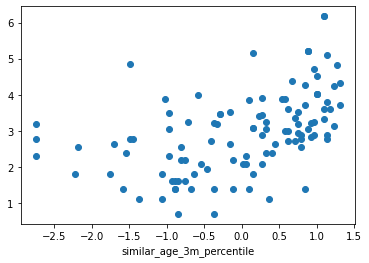

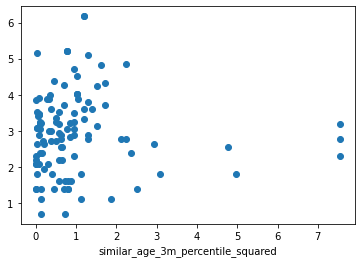

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     9.770
Date:                Thu, 05 Jan 2023   Prob (F-statistic):           1.60e-08
Time:                        18:24:12   Log-Likelihood:                -145.79
No. Observations:                 111   AIC:                             305.6
Df Residuals:                     104   BIC:                             324.5
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
refere

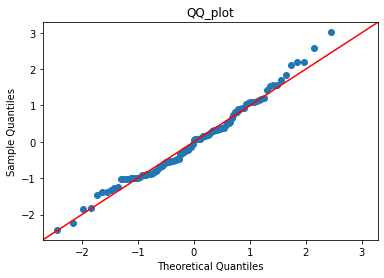

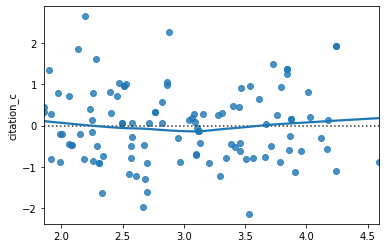

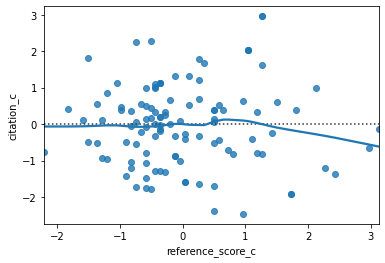

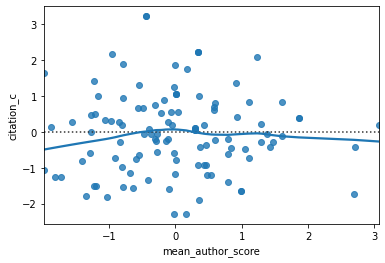

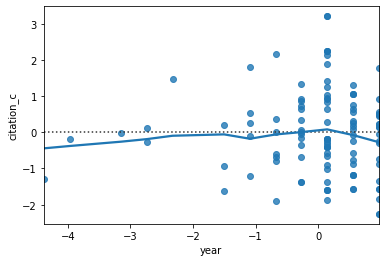

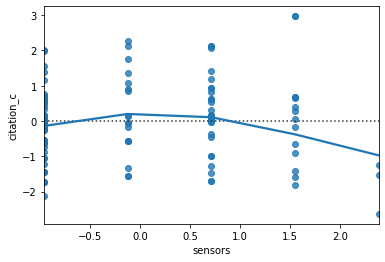

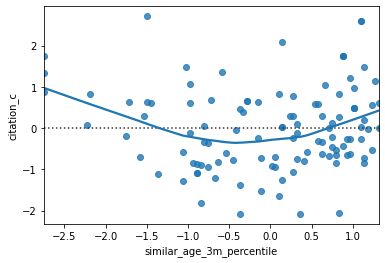

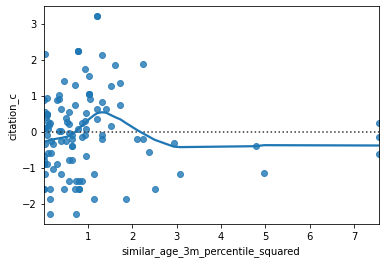

4443.306634384559


In [20]:
df = create_modelling_df_no_frames(retrieved_data, 3, 0, 1)
modelling_df = convert_and_plot_data(df)
modelling_df_normalized = normalize(modelling_df)
modelling_df_normalized["similar_age_3m_percentile_squared"] = modelling_df_normalized.similar_age_3m_percentile.pow(2)
res_NO_frames, fitted_y, y_ols, x = modelling(modelling_df_normalized, show_summary=True)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)

In [21]:
#save result
with open("output/regression_NO_frames_years.csv", 'w') as csvFile:
    single = res_NO_frames.summary().as_csv()
    lns = single.split(";")
    for item in lns:
        csvFile.write(item.replace("=", ",") + os.linesep)

100%|██████████| 205/205 [00:02<00:00, 82.93it/s] 


Missing Data (due to missing features): 161
Missing Data (due to year): 13
Missing values: altmetrics: 66 frames 85 sensors 10
missing due to (other features available) frames 47 sensors 0 altmetrics 36


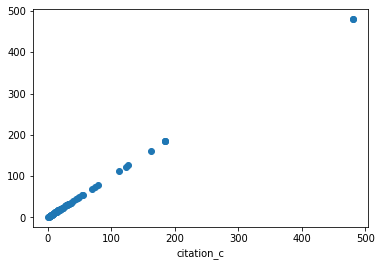

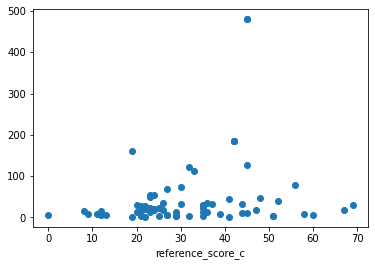

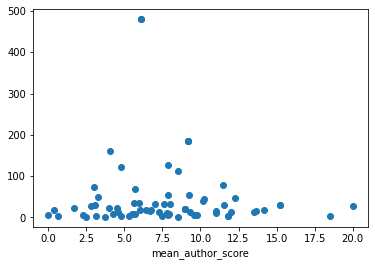

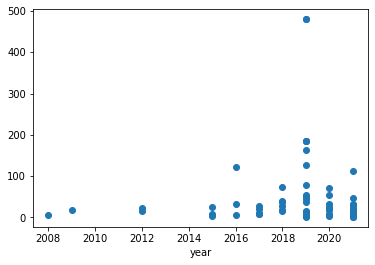

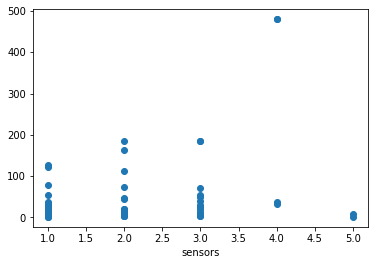

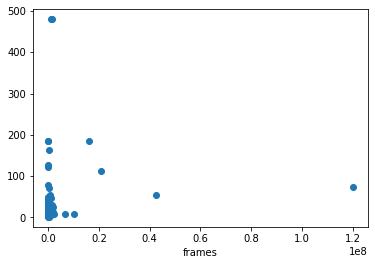

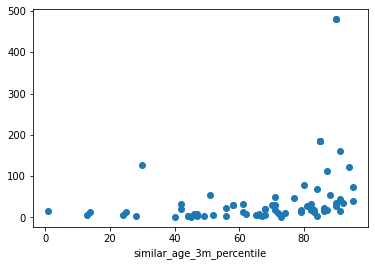

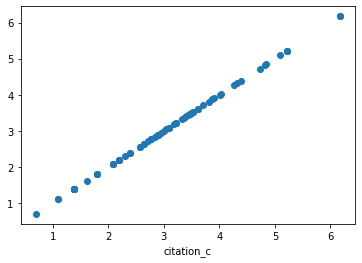

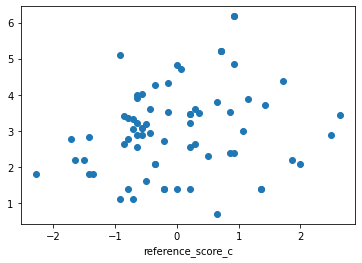

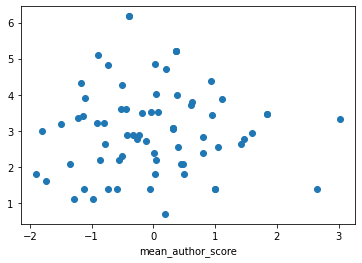

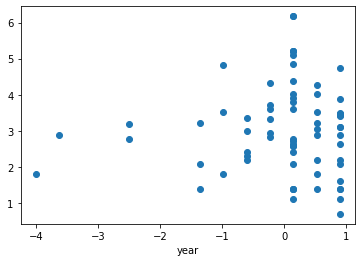

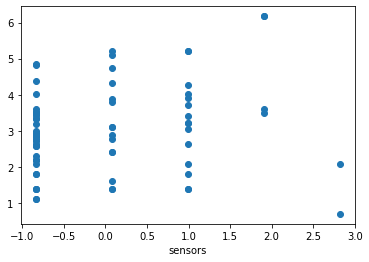

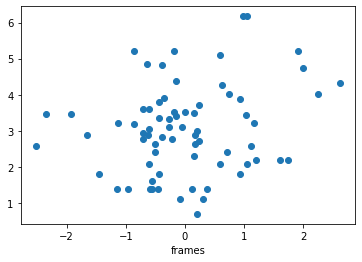

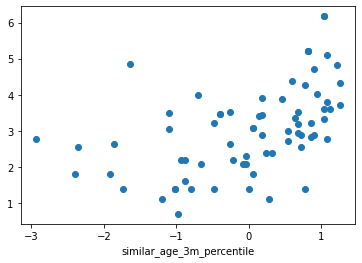

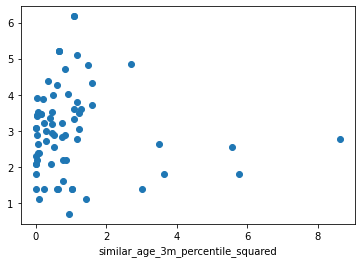

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     6.874
Date:                Thu, 05 Jan 2023   Prob (F-statistic):           4.52e-06
Time:                        18:24:19   Log-Likelihood:                -95.815
No. Observations:                  71   AIC:                             207.6
Df Residuals:                      63   BIC:                             225.7
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
refere

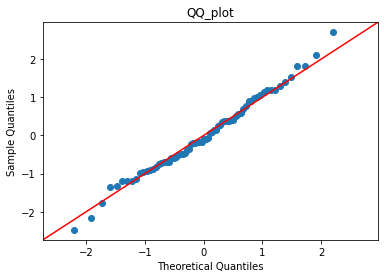

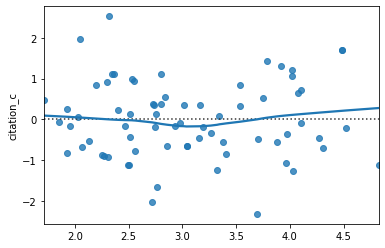

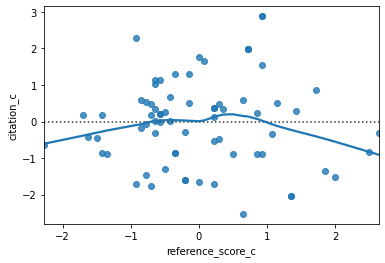

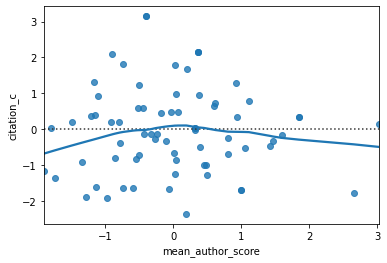

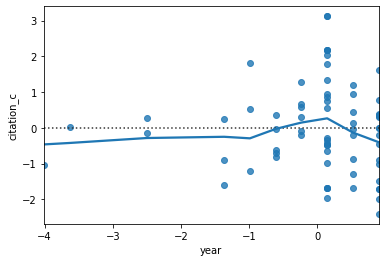

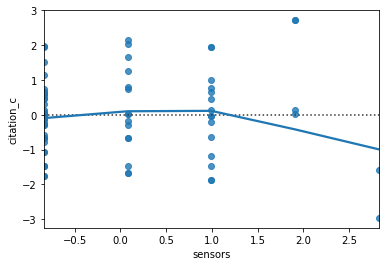

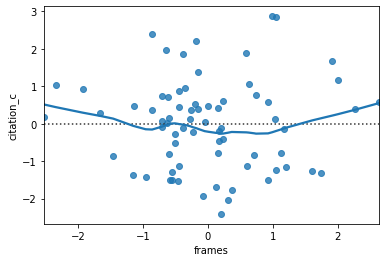

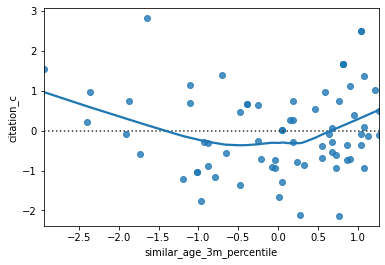

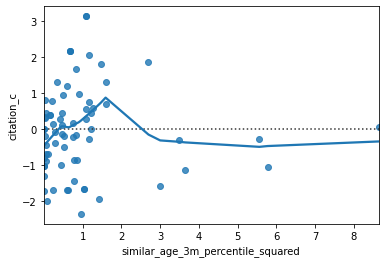

5953.927843801204


In [22]:
df = create_modelling_df_altmetric_sensor(retrieved_data, 3, 0, 1)
modelling_df = convert_and_plot_data(df)
modelling_df_normalized = normalize(modelling_df)
modelling_df_normalized["similar_age_3m_percentile_squared"] = modelling_df_normalized.similar_age_3m_percentile.pow(2)
res_frames, fitted_y, y_ols, x = modelling(modelling_df_normalized, show_summary=True)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)

[3.7832   3.616864 3.459316 3.310556 3.170584 3.0394   2.917004 2.803396
 2.698576 2.602544 2.5153   2.436844 2.367176 2.306296 2.254204 2.2109
 2.176384 2.150656 2.133716 2.125564 2.1262   2.135624 2.153836 2.180836
 2.216624 2.2612   2.314564 2.376716 2.447656 2.527384 2.6159   2.713204
 2.819296 2.934176 3.057844 3.1903   3.331544 3.481576 3.640396 3.808004
 3.9844   4.169584 4.363556 4.566316 4.777864]


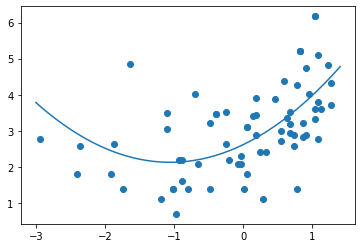

In [23]:
x = np.array([*range(-30, 15, 1)])/10
y = 2.6159 + 0.9291*x + 0.4394*x**2
print(y)
plt.plot(x, y)
plt.scatter(modelling_df_normalized.similar_age_3m_percentile, modelling_df_normalized.citation_c)
plt.show()

In [24]:
'''df = create_modelling_df_altmetric_sensor(retrieved_data, 3, 0, 1)
modelling_df = convert_and_plot_data(df)
modelling_df_normalized = normalize(modelling_df)
def inverse_normalize_data(ls, original, feature):
    print(original[feature].mean())
    return (ls+ original[feature].mean()) * original[feature].std()
x_scaled = inverse_normalize_data(x, modelling_df, 'similar_age_3m_percentile')
y_scaled = inverse_normalize_data(y, modelling_df, 'citation_c')
def inverse_normalize(df, original, feature):
    return (df[feature]+ original[feature].mean()) * original[feature].std()
rescaled_citations = inverse_normalize(modelling_df_normalized, modelling_df, 'citation_c')
rescaled_aas = inverse_normalize(modelling_df_normalized, modelling_df, 'similar_age_3m_percentile')
plt.plot(x_scaled, y_scaled)
plt.scatter(rescaled_aas, rescaled_citations)
plt.show()'''

"df = create_modelling_df_altmetric_sensor(retrieved_data, 3, 0, 1)\nmodelling_df = convert_and_plot_data(df)\nmodelling_df_normalized = normalize(modelling_df)\ndef inverse_normalize_data(ls, original, feature):\n    print(original[feature].mean())\n    return (ls+ original[feature].mean()) * original[feature].std()\nx_scaled = inverse_normalize_data(x, modelling_df, 'similar_age_3m_percentile')\ny_scaled = inverse_normalize_data(y, modelling_df, 'citation_c')\ndef inverse_normalize(df, original, feature):\n    return (df[feature]+ original[feature].mean()) * original[feature].std()\nrescaled_citations = inverse_normalize(modelling_df_normalized, modelling_df, 'citation_c')\nrescaled_aas = inverse_normalize(modelling_df_normalized, modelling_df, 'similar_age_3m_percentile')\nplt.plot(x_scaled, y_scaled)\nplt.scatter(rescaled_aas, rescaled_citations)\nplt.show()"

100%|██████████| 205/205 [00:02<00:00, 75.48it/s]

Missing Data (due to missing features): 161
Missing Data (due to year): 13
Missing values: altmetrics: 66 frames 85 sensors 10
missing due to (other features available) frames 47 sensors 0 altmetrics 36


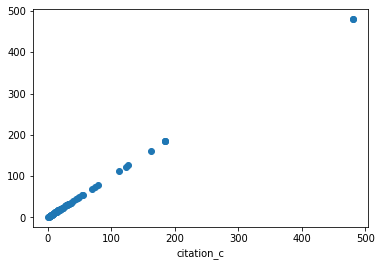

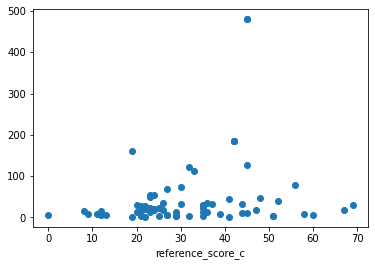

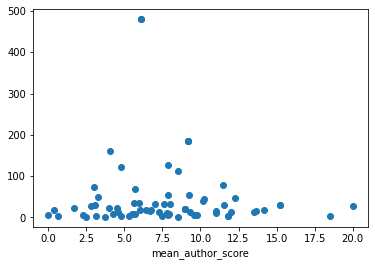

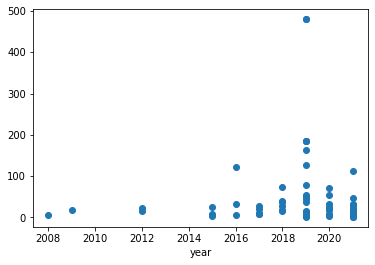

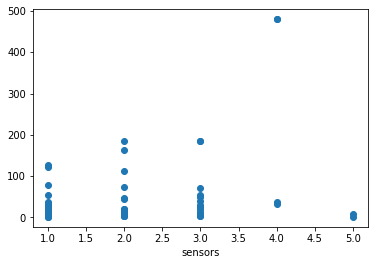

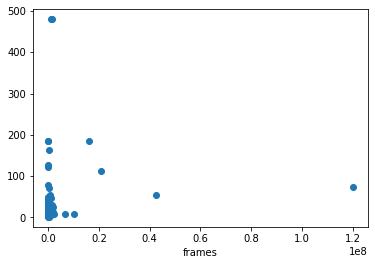

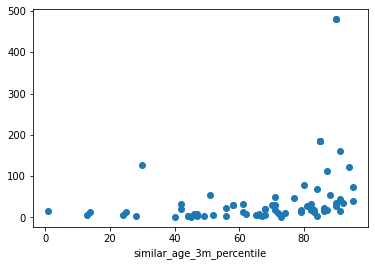

nuImages                 1.038662
nuScenes                 1.038662
GTA5                     1.217438
CamVid                   0.904581
Waymo Open Perception    1.083356
                           ...   
MOTSynth                 0.189477
SeeingThroughFog        -0.033993
SODA10M                 -0.212768
Synthetic Discrepancy   -2.358078
TITAN                   -0.257462
Name: similar_age_3m_percentile, Length: 71, dtype: float64

In [25]:
df = create_modelling_df_altmetric_sensor(retrieved_data, 3, 0, 1)
modelling_df = convert_and_plot_data(df)
modelling_df_normalized = normalize(modelling_df)
modelling_df_normalized.similar_age_3m_percentile

In [26]:
#save result
with open("output/regression_frames_years.csv", 'w') as csvFile:
    single = res_frames.summary().as_csv()
    lns = single.split(";")
    for item in lns:
        csvFile.write(item.replace("=", ",") + os.linesep)

Making Citation Predictor with XGB - no good results

In [27]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    modelling_df.drop(['citation_c'], axis=1), modelling_df['citation_c'], test_size=0.3, random_state=13
)
X_train, X_fin, y_train, y_fin = train_test_split(
    X_test, y_test, test_size=0.3, random_state=13
)

In [29]:
params = {
    "n_estimators": 10,
    "max_depth": 20,
    "min_samples_split": 3,
    "learning_rate": 0.8,
    "loss": "squared_error",
}

In [30]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.8, max_depth=20, min_samples_split=3,
                          n_estimators=10)

In [31]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
r2 = r2_score(y_test, reg.predict(X_test))
print("The R squared  (R2) on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 0.3594
The R squared  (R2) on test set: 0.7964


The mean absolute error (MAE) on test set: 18.8301
The mean squared error (MSE) on test set: 2534.8182


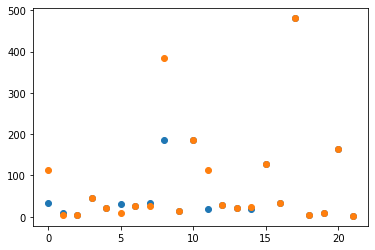

In [32]:

comparison = [np.exp(y_test), np.exp(reg.predict(X_test))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(y_test))], comparison[0])
plt.scatter([*range(len(y_test))], comparison[1])
plt.show()

The mean absolute error (MAE) on test set: 59.1801
The mean squared error (MSE) on test set: 7966.5716


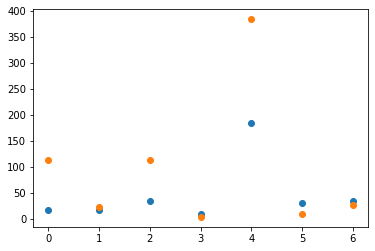

In [33]:
comparison = [np.exp(y_fin), np.exp(reg.predict(X_fin))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(comparison[0]))], comparison[0])
plt.scatter([*range(len(comparison[0]))], comparison[1])
plt.show()

### Table of Features and Influence Score of all papers from 2022

In [34]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests', suffix)
retrieved_data =  []
print('Importing data again')
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Importing data again


In [38]:
for paper in retrieved_data:
    if paper['id'][0] == 'W':
        print(paper['id'])

Waymo Open Perception
WoodScape
Waymo Open Motion
WildDash
Waymo Block-NeRF
WildDash 2
WZ-traffic
Wuppertal Obstacle Sequences (WOS)


In [40]:
target = 'Wuppertal Obstacle Sequences (WOS)'
for paper in retrieved_data:
    if paper['id'] == target:
        print(paper['paperInfo']['year'])

2022


Make array with all features of all data to calculate percentile ranks

In [41]:
yr = 2022
array = np.empty([len(retrieved_data), 9])
array[:] = np.nan
names = []
'''
self.lower_bound = 2019 = o_paper['paperInfo']['year'] - (o_paper['paperInfo']['year'] - 2022 + 3)# years prior to the publication used for calculating various scores
self.upper_bound = 2022 = o_paper['paperInfo']['year'] + (-o_paper['paperInfo']['year']+2022) # year after publication used for calculating various scores
self.impact_year = 2022 = o_paper['paperInfo']['year'] + impact_year # year(s) after publication when we want to know a papers impact
'''
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    dist = 2022 - o_paper['paperInfo']['year'] #2022 - o_paper['paperInfo']['year']

    scorer = scoring(o_paper, -dist+2, dist, dist)
    reference = scorer.reference_score()
    citations_citations = scorer.citations_citations_score()
    citations = scorer.just_citations()

    print(paper_idx, o_paper['id'], 'citations', citations, 'year:', o_paper['paperInfo']['year'])
    print('scorer', scorer.lower_bound, scorer.upper_bound, scorer.impact_year)

    ls_author_scores = []
    names.append(o_paper['id'])
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(author_number)
        ls_author_scores.append(single_author_score)
    author = np.mean(ls_author_scores)
    try:
        score = o_paper['altmetrics'][0]['score']
    except:
        score = float("NaN")
    try:
        total_readers = o_paper['altmetrics'][3]['total_readers']
    except:
        total_readers = float("NaN")
    try:
        sensors_value = int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_value = float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_value = int(o_paper['frames'].replace(',', ''))
        else:
            frames_value = float("NaN")
    except:
                frames_value = float("NaN")
    publication = o_paper['paperInfo']['year']


    array[paper_idx][:] = [citations, citations_citations, total_readers, score, reference, author, sensors_value, frames_value, publication]

  2%|▏         | 4/205 [00:00<00:17, 11.77it/s]

0 KITTI citations 3049 year: 2013
scorer 2020 2022 2022
1 Cars citations 1321 year: 2013
scorer 2020 2022 2022
2 nuImages citations 1749 year: 2019
scorer 2020 2022 2022
3 nuScenes citations 1749 year: 2019
scorer 2020 2022 2022
4 Synthia citations 932 year: 2016
scorer 2020 2022 2022
5 GTA5 citations 793 year: 2016
scorer 2020 2022 2022


  5%|▌         | 11/205 [00:00<00:08, 22.07it/s]

6 Caltech Pedestrian citations 338 year: 2009
scorer 2020 2022 2022
7 CamVid citations 473 year: 2009
scorer 2020 2022 2022
8 Oxford Robot Car citations 632 year: 2017
scorer 2020 2022 2022
9 Waymo Open Perception citations 906 year: 2019
scorer 2020 2022 2022
10 Mapillary Vistas citations 539 year: 2017
scorer 2020 2022 2022
11 GTSRB citations 320 year: 2011
scorer 2020 2022 2022
12 Caltech Lanes citations 204 year: 2008
scorer 2020 2022 2022
13 BDD100k citations 625 year: 2018
scorer 2020 2022 2022


 11%|█         | 23/205 [00:00<00:05, 35.86it/s]

14 ETH Pedestrian citations 143 year: 2008
scorer 2020 2022 2022
15 Beyond PASCAL citations 250 year: 2014
scorer 2020 2022 2022
16 Argoverse 3D Tracking citations 572 year: 2019
scorer 2020 2022 2022
17 Argoverse Motion Forecasting citations 572 year: 2019
scorer 2020 2022 2022
18 GTSDB citations 271 year: 2013
scorer 2020 2022 2022
19 LISA Traffic Sign citations 169 year: 2012
scorer 2020 2022 2022
20 Stanford Drone citations 336 year: 2016
scorer 2020 2022 2022
21 TT100K citations 242 year: 2016
scorer 2020 2022 2022
22 CULane citations 363 year: 2017
scorer 2020 2022 2022


 19%|█▉        | 39/205 [00:01<00:03, 53.09it/s]

23 TUD Brussels citations 59 year: 2009
scorer 2020 2022 2022
24 highD citations 364 year: 2018
scorer 2020 2022 2022
25 Ford CAMPUS citations 112 year: 2011
scorer 2020 2022 2022
26 ApolloScape citations 246 year: 2018
scorer 2020 2022 2022
27 Road Damage citations 194 year: 2018
scorer 2020 2022 2022
28 VPGNet citations 205 year: 2017
scorer 2020 2022 2022
29 DDAD citations 269 year: 2019
scorer 2020 2022 2022
30 NCLT citations 162 year: 2016
scorer 2020 2022 2022
31 NoCrash citations 208 year: 2019
scorer 2020 2022 2022
32 Multi Vehicle Stereo Event Camera citations 168 year: 2018
scorer 2020 2022 2022
33 Malaga Stereo and Laser Urban citations 91 year: 2014
scorer 2020 2022 2022
34 INTERACTION citations 195 year: 2019
scorer 2020 2022 2022
35 Daimler Pedestrian Path Prediction Benchmark citations 67 year: 2013
scorer 2020 2022 2022
36 comma.ai citations 80 year: 2016
scorer 2020 2022 2022
37 Oxford Radar Robot Car citations 170 year: 2019
scorer 2020 2022 2022
38 India Driving cita

 26%|██▋       | 54/205 [00:01<00:02, 62.42it/s]

39 Stanford Track Collection citations 34 year: 2011
scorer 2020 2022 2022
40 LISA Traffic Light citations 68 year: 2016
scorer 2020 2022 2022
41 Bosch Small Traffic Lights Dataset citations 90 year: 2017
scorer 2020 2022 2022
42 Bosch TL citations 90 year: 2017
scorer 2020 2022 2022
43 DR(eye)VE citations 107 year: 2017
scorer 2020 2022 2022
44 Toronto City citations 53 year: 2016
scorer 2020 2022 2022
45 KITTI-360 citations 81 year: 2015
scorer 2020 2022 2022
46 Nighttime Driving citations 112 year: 2018
scorer 2020 2022 2022
47 JAAD citations 106 year: 2017
scorer 2020 2022 2022
48 KAIST Multi-Spectral Day/Night citations 117 year: 2018
scorer 2020 2022 2022
49 inD citations 134 year: 2019
scorer 2020 2022 2022
50 TME Motorway citations 22 year: 2012
scorer 2020 2022 2022
51 Lyft Level5 Perception citations 127 year: 2020
scorer 2020 2022 2022
52 Lyft Level5 Prediction citations 127 year: 2020
scorer 2020 2022 2022
53 One Thousand and One Hours citations 127 year: 2020
scorer 2020 2

 35%|███▍      | 71/205 [00:01<00:01, 68.01it/s]

57 Complex Urban citations 104 year: 2019
scorer 2020 2022 2022
58 Waymo Open Motion citations 111 year: 2021
scorer 2020 2022 2022
59 Synscapes citations 93 year: 2018
scorer 2020 2022 2022
60 WildDash citations 86 year: 2018
scorer 2020 2022 2022
61 Five Roundabouts citations 87 year: 2018
scorer 2020 2022 2022
62 BoxCars116k citations 69 year: 2017
scorer 2020 2022 2022
63 UAH-DriveSet citations 60 year: 2016
scorer 2020 2022 2022
64 Ground Truth Stixel citations 11 year: 2013
scorer 2020 2022 2022
65 Waymo Block-NeRF citations 88 year: 2022
scorer 2020 2022 2022
66 DBNet citations 52 year: 2018
scorer 2020 2022 2022
67 LiDAR-Video Driving citations 52 year: 2018
scorer 2020 2022 2022
68 LostAndFound citations 63 year: 2016
scorer 2020 2022 2022
69 Daimler Stereo Pedestrian Detection Benchmark citations 6 year: 2011
scorer 2020 2022 2022
70 HD1K citations 59 year: 2016
scorer 2020 2022 2022
71 Tsinghua Daimler Cyclist Detection citations 33 year: 2016
scorer 2020 2022 2022
72 CADC c

 41%|████▏     | 85/205 [00:01<00:01, 67.49it/s]

73 Street Hazards citations 72 year: 2022
scorer 2020 2022 2022
74 HCI Challenging Stereo citations 10 year: 2012
scorer 2020 2022 2022
75 Toronto 3D citations 68 year: 2020
scorer 2020 2022 2022
76 Fishyscapes citations 60 year: 2019
scorer 2020 2022 2022
77 A*3D citations 53 year: 2019
scorer 2020 2022 2022
78 NightOwls citations 44 year: 2018
scorer 2020 2022 2022
79 RELLIS-3D citations 50 year: 2020
scorer 2020 2022 2022
80 EuroCity Persons citations 112 year: 2019
scorer 2020 2022 2022
81 SemanticPOSS citations 49 year: 2020
scorer 2020 2022 2022
82 ONCE citations 47 year: 2021
scorer 2020 2022 2022
83 rounD citations 45 year: 2020
scorer 2020 2022 2022
84 PointCloudDeNoising citations 34 year: 2019
scorer 2020 2022 2022
85 Ford Autonomous Vehicle citations 41 year: 2020
scorer 2020 2022 2022
86 CADP citations 32 year: 2018
scorer 2020 2022 2022
87 LIBRE citations 41 year: 2020
scorer 2020 2022 2022


 48%|████▊     | 99/205 [00:02<00:01, 64.28it/s]

88 CARRADA citations 37 year: 2020
scorer 2020 2022 2022
89 D^2 City citations 34 year: 2019
scorer 2020 2022 2022
90 A Parametric Top-View Representation of Complex Road Scenes citations 30 year: 2018
scorer 2020 2022 2022
91 Comma2k19 citations 30 year: 2018
scorer 2020 2022 2022
92 Daimler Pedestrian Segmentation Benchmark citations 14 year: 2013
scorer 2020 2022 2022
93 RADIATE citations 27 year: 2020
scorer 2020 2022 2022
94 Street Learn citations 24 year: 2019
scorer 2020 2022 2022
95 Talk2Car citations 30 year: 2019
scorer 2020 2022 2022
96 DIPLECS Autonomous Driving citations 18 year: 2015
scorer 2020 2022 2022
97 RoadAnomaly21 citations 31 year: 2021
scorer 2020 2022 2022
98 RoadObstacle21 citations 31 year: 2021
scorer 2020 2022 2022
99 Raincouver citations 21 year: 2017
scorer 2020 2022 2022
100 PandaSet citations 29 year: 2021
scorer 2020 2022 2022
101 4Seasons citations 28 year: 2020
scorer 2020 2022 2022
102 BLVD citations 21 year: 2019
scorer 2020 2022 2022
103 DDD20: DA

 52%|█████▏    | 106/205 [00:02<00:02, 36.79it/s]

104 MTSD citations 26 year: 2019
scorer 2020 2022 2022
105 Unsupervised Llamas citations 26 year: 2019
scorer 2020 2022 2022
106 Bay Area citations 8 year: 2014
scorer 2020 2022 2022
107 DriveU Traffic Light citations 15 year: 2018
scorer 2020 2022 2022
108 Illumination Changes in a day citations 8 year: 2014
scorer 2020 2022 2022
109 RANUS citations 17 year: 2018
scorer 2020 2022 2022
110 Seasonal Variation citations 8 year: 2014
scorer 2020 2022 2022


 57%|█████▋    | 117/205 [00:02<00:02, 34.02it/s]

111 CCSAD citations 10 year: 2015
scorer 2020 2022 2022
112 Cityscapes 3D citations 22 year: 2020
scorer 2020 2022 2022
113 nuPlan citations 23 year: 2021
scorer 2020 2022 2022
114 PREVENTION citations 23 year: 2019
scorer 2020 2022 2022
115 RadarScenes citations 23 year: 2021
scorer 2020 2022 2022
116 KITTI-360 PanopticBEV citations 21 year: 2021
scorer 2020 2022 2022
117 nuScenes PanopticBEV citations 21 year: 2021
scorer 2020 2022 2022
118 AMUSE citations 8 year: 2013
scorer 2020 2022 2022


 60%|█████▉    | 122/205 [00:03<00:03, 26.37it/s]

119 Boxy citations 16 year: 2019
scorer 2020 2022 2022
120 ROAD citations 17 year: 2021
scorer 2020 2022 2022
121 TAF-BW citations 12 year: 2018
scorer 2020 2022 2022
122 Brain4Cars citations 77 year: 2015
scorer 2020 2022 2022


 61%|██████▏   | 126/205 [00:03<00:03, 24.66it/s]

123 openDD citations 14 year: 2020
scorer 2020 2022 2022
124 MCity Data Collection citations 11 year: 2019
scorer 2020 2022 2022
125 Semantic KITTI citations 638 year: 2019
scorer 2020 2022 2022
126 SemanticUSL citations 13 year: 2021
scorer 2020 2022 2022
127 TRoM citations 6 year: 2017
scorer 2020 2022 2022


 64%|██████▍   | 132/205 [00:03<00:03, 22.87it/s]

128 SHIFT citations 8 year: 2022
scorer 2020 2022 2022
129 Small Obstacle citations 8 year: 2020
scorer 2020 2022 2022
130 Cooperative Driving (CODD) citations 7 year: 2021
scorer 2020 2022 2022
131 PepScenes citations 6 year: 2020
scorer 2020 2022 2022
132 ScribbleKITTI citations 6 year: 2022
scorer 2020 2022 2022


 67%|██████▋   | 138/205 [00:03<00:03, 19.87it/s]

133 DriveSeg (MANUAL) citations 5 year: 2019
scorer 2020 2022 2022
134 DriveSeg (Semi-auto) citations 5 year: 2019
scorer 2020 2022 2022
135 K-Lane citations 4 year: 2021
scorer 2020 2022 2022
136 WildDash 2 citations 4 year: 2022
scorer 2020 2022 2022
137 WZ-traffic citations 4 year: 2019
scorer 2020 2022 2022
138 Automatum (Open Highway) citations 3 year: 2021
scorer 2020 2022 2022


 70%|███████   | 144/205 [00:04<00:02, 21.50it/s]

139 CrashD citations 3 year: 2021
scorer 2020 2022 2022
140 Ithaca365 citations 3 year: 2022
scorer 2020 2022 2022
141 Comma2k19 LD citations 2 year: 2022
scorer 2020 2022 2022
142 exiD citations 2 year: 2022
scorer 2020 2022 2022
143 GROUNDED citations 2 year: 2021
scorer 2020 2022 2022
144 Provident Vehicle Detection at Night (PVDN) citations 2 year: 2021
scorer 2020 2022 2022
145 TJ4DRadSet citations 2 year: 2022
scorer 2020 2022 2022
146 Amodal Cityscapes citations 1 year: 2022
scorer 2020 2022 2022


 74%|███████▎  | 151/205 [00:04<00:02, 23.86it/s]

147 DRIV100 citations 1 year: 2021
scorer 2020 2022 2022
148 LUMPI citations 1 year: 2022
scorer 2020 2022 2022
149 MIT-AVT Clustered Driving Scene citations 1 year: 2020
scorer 2020 2022 2022
150 RoadSaW citations 1 year: 2022
scorer 2020 2022 2022
151 SceNDD citations 1 year: 2022
scorer 2020 2022 2022
152 VLMV - Vehicle Lane Merge Visual Benchmark citations 1 year: 2021
scorer 2020 2022 2022
153 A9 citations 8 year: 2022
scorer 2020 2022 2022
154 aiMotive citations 0 year: 2022
scorer 2020 2022 2022


 78%|███████▊  | 159/205 [00:04<00:01, 24.05it/s]

155 Argoverse 1 Stereo citations 572 year: 2019
scorer 2020 2022 2022
156 Argoverse 2 Lidar citations 52 year: 2023
scorer 2020 2022 2022
157 Argoverse 2 Map Change citations 52 year: 2023
scorer 2020 2022 2022
158 Argoverse 2 Motion Forecasting citations 52 year: 2023
scorer 2020 2022 2022
159 Argoverse 2 Sensor citations 52 year: 2023
scorer 2020 2022 2022


 80%|████████  | 165/205 [00:05<00:01, 22.18it/s]

160 AugKITTI citations 0 year: 2022
scorer 2020 2022 2022
161 Autonomous Platform Inertial citations 6 year: 2022
scorer 2020 2022 2022
162 BDD100K-APS citations 7 year: 2022
scorer 2020 2022 2022
163 Boreas citations 11 year: 2022
scorer 2020 2022 2022
164 CarlaScenes citations 0 year: 2022
scorer 2020 2022 2022
165 CARLA-WildLife (CWL) citations 0 year: 2022
scorer 2020 2022 2022
166 Cityscapes-DVPS citations 58 year: 2020
scorer 2020 2022 2022


 83%|████████▎ | 171/205 [00:05<00:02, 14.60it/s]

167 CODA citations 6 year: 2022
scorer 2020 2022 2022
168 CURE-TSD citations 32 year: 2019
scorer 2020 2022 2022
169 CURE-TSR citations 29 year: 2017
scorer 2020 2022 2022
170 DGL-MOTS citations 336 year: 2019
scorer 2020 2022 2022


 86%|████████▋ | 177/205 [00:06<00:01, 14.84it/s]

171 Gated2Depth citations 22 year: 2019
scorer 2020 2022 2022
172 Gated2Gated citations 1 year: 2021
scorer 2020 2022 2022
173 GLARE citations 0 year: 2022
scorer 2020 2022 2022
174 HAD citations 27 year: 2019
scorer 2020 2022 2022
175 HDBD citations 0 year: 2022
scorer 2020 2022 2022
176 HDD citations 109 year: 2018
scorer 2020 2022 2022


 90%|████████▉ | 184/205 [00:06<00:00, 21.02it/s]

177 HEV-I citations 61 year: 2018
scorer 2020 2022 2022
178 HSD citations 12 year: 2019
scorer 2020 2022 2022
179 IDDA citations 20 year: 2020
scorer 2020 2022 2022
180 IPS300+ citations 3 year: 2021
scorer 2020 2022 2022
181 I see you citations 0 year: 2022
scorer 2020 2022 2022
182 KITTI-360-APS citations 7 year: 2022
scorer 2020 2022 2022
183 K-Radar citations 1 year: 2022
scorer 2020 2022 2022
184 LISA Amazon-MLSL Vehicle Attributes (LAVA) citations 0 year: 2021
scorer 2020 2022 2022
185 LOKI citations 12 year: 2021
scorer 2020 2022 2022


 93%|█████████▎| 191/205 [00:06<00:00, 23.69it/s]

186 MAVD Multimodal Audio-Visual Detection citations 32 year: 2021
scorer 2020 2022 2022
187 MONA: The Munich Motion Dataset of Natural Driving citations 0 year: 2022
scorer 2020 2022 2022
188 MOTSynth citations 30 year: 2021
scorer 2020 2022 2022
189 MuIRan citations 92 year: 2020
scorer 2020 2022 2022
190 OpenMPD citations 5 year: 2022
scorer 2020 2022 2022
191 PIE citations 97 year: 2019
scorer 2020 2022 2022
192 R3 Driving citations 0 year: 2021
scorer 2020 2022 2022
193 Rope3D citations 3 year: 2022
scorer 2020 2022 2022


 96%|█████████▌| 197/205 [00:06<00:00, 20.78it/s]

194 RUGD: Robot Unstructured Ground Driving citations 48 year: 2019
scorer 2020 2022 2022
195 R-U-MAAD citations 0 year: 2022
scorer 2020 2022 2022
196 SeeingThroughFog citations 104 year: 2019
scorer 2020 2022 2022
197 SemKITTI-DVPS citations 58 year: 2020
scorer 2020 2022 2022
198 SODA10M citations 8 year: 2021
scorer 2020 2022 2022


100%|██████████| 205/205 [00:07<00:00, 27.14it/s]

199 Street Obstacle Sequences (SOS) citations 0 year: 2022
scorer 2020 2022 2022
200 Synthetic Discrepancy citations 63 year: 2019
scorer 2020 2022 2022
201 TITAN citations 53 year: 2020
scorer 2020 2022 2022
202 USyd Campus citations 8 year: 2020
scorer 2020 2022 2022
203 UTBM EU LTD citations 33 year: 2019
scorer 2020 2022 2022
204 Wuppertal Obstacle Sequences (WOS) citations 0 year: 2022
scorer 2020 2022 2022


In [42]:
'''c = 0
for citation in retrieved_data[59]['paperInfo']['citations']:
    if citation['year']:
        c += 1
c'''

"c = 0\nfor citation in retrieved_data[59]['paperInfo']['citations']:\n    if citation['year']:\n        c += 1\nc"

In [49]:
df_features_IS = pd.DataFrame(array, columns=['citations', 'citations_citations', 'total_readers', 'score', 'reference', 'author', 'sensors_abs', 'frames_abs', 'publicationYear']).set_axis(names).drop_duplicates()
df_features_IS['cit'] = df_features_IS.citations.rank(pct = True)
df_features_IS['h-cit'] = df_features_IS.citations_citations.rank(pct = True)
df_features_IS['refs'] = df_features_IS.reference.rank(pct = True)
df_features_IS['authors'] = df_features_IS.author.rank(pct = True)
df_features_IS['sensors'] = df_features_IS.sensors_abs.rank(pct = True)
df_features_IS['frames'] = df_features_IS.frames_abs.rank(pct = True)
df_features_IS['Altmetric'] = df_features_IS.score.rank(pct = True)
df_features_IS['readers'] = df_features_IS.total_readers.rank(pct = True)
df_features_IS


,citations,citations_citations,total_readers,score,reference,author,sensors_abs,frames_abs,publicationYear,cit,h-cit,refs,authors,sensors,frames,Altmetric,readers
KITTI,3049.0,138.0,2012.0,12.25,9.0,30.250000,3.0,NaN,2013.0,1.000000,1.000000,0.053659,0.985366,0.771795,NaN,0.831461,1.000000
Cars,1321.0,103.0,365.0,3.00,23.0,18.750000,1.0,16185.0,2013.0,0.985366,0.990244,0.395122,0.892683,0.246154,0.302521,0.494382,0.876404
nuImages,1749.0,71.0,1254.0,23.08,63.0,6.800000,4.0,1200000.0,2019.0,0.992683,0.965854,0.956098,0.226829,0.928205,0.882353,0.929775,0.991573
nuScenes,1749.0,71.0,1254.0,23.08,63.0,6.800000,4.0,1400000.0,2019.0,0.992683,0.965854,0.956098,0.226829,0.928205,0.903361,0.929775,0.991573
Synthia,932.0,107.0,741.0,9.00,31.0,9.000000,1.0,213400.0,2016.0,0.980488,0.995122,0.648780,0.407317,0.246154,0.764706,0.741573,0.983146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Synthetic Discrepancy,63.0,14.0,208.0,0.50,41.0,21.250000,1.0,60.0,2019.0,0.646341,0.639024,0.836585,0.926829,0.246154,0.008403,0.179775,0.752809
TITAN,53.0,10.0,219.0,3.50,51.0,9.666667,1.0,75262.0,2020.0,0.600000,0.534146,0.914634,0.443902,0.246154,0.588235,0.550562,0.769663
USyd Campus,8.0,2.0,9.0,2.00,19.0,9.857143,5.0,NaN,2020.0,0.253659,0.202439,0.270732,0.463415,0.992308,NaN,0.387640,0.115169
UTBM EU LTD,33.0,8.0,64.0,0.25,23.0,14.500000,4.0,NaN,2019.0,0.500000,0.475610,0.395122,0.736585,0.928205,NaN,0.157303,0.443820


In [50]:
df_features_IS = df_features_IS.iloc[:, -9:]


In [51]:
def influence_score(scores, weights=[1, 1, 1, 1, 1, 1, 1, 1], selected_features='default'):
    """Calculates Influence score of one paper based on given weights. IS=sum(weight_i*feature_i). Summ of weights is 1. Missing features are omitted and the remaining weights are rescaled so that their sum is equal to one. """
    weights = np.array(weights, dtype=float)
    #make array with all available features, i.e. exclude NaNs
    if selected_features == 'default': # no sensors
        selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
    if selected_features == 'all':
        selected_features = scores.index
        #print(selected_features)
    ls_available_features = []
    for index_feature, feature in enumerate(selected_features):
        if not np.isnan(scores[feature]):
            ls_available_features.append((index_feature, feature))
            #print(feature)

    #scale weights
    if len(ls_available_features) != len(weights):
        weights_to_scale = np.zeros(len(ls_available_features))
        for index_insert, feature in enumerate(ls_available_features):
            weights_to_scale[index_insert] = weights[feature[0]]
        weights = weights_to_scale

    weights /= np.sum(weights)
    assert np.sum(weights) == pytest.approx(1)
    #print('Scaled weights:', weights)
    #print('Available features', len(ls_available_features), ls_available_features)
    #calculate score
    result = 0
    for index, feature in enumerate(ls_available_features):
        #print(result)
        #print(feature)
        result += weights[index]*scores[feature[1]]
        #print(feature[1], weights[index], scores[feature[1]])
    assert 0 <= result <= 1
    return result

In [52]:
influence_score(df_features_IS.iloc[0], selected_features='default')

0.8117475107335341

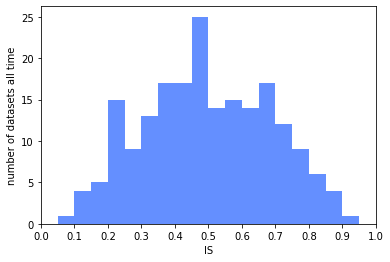

In [53]:
df_features_IS_all_time = df_features_IS.drop('publicationYear',axis=1).drop_duplicates()
ls_influence_score_all_time = []
for dataset in df_features_IS_all_time.index:
    ls_influence_score_all_time.append(influence_score(df_features_IS_all_time.loc[dataset])) #, weights=[0, 1, 0, 0, 0, 0, 0, 0]
ls_influence_score_all_time

plt.hist(ls_influence_score_all_time, bins=20, range=(0,1), color='#648fff')
plt.xlabel('IS')
plt.ylabel('number of datasets all time')
plt.xlim((0,1))
plt.xticks(np.array([*range(0, 11)])/10)
plt.savefig('output/hist_all_at_influence_score.pdf')
plt.show()

Subset with papers from 2022 and add column with influence score


In [54]:
df_features_IS_2022 = df_features_IS.loc[df_features_IS['publicationYear']==2022] #just datasets from 2022
df_features_IS_2022 = df_features_IS_2022.drop('publicationYear', axis=1)
ls_influence_score = []
for dataset in df_features_IS_2022.index:
    ls_influence_score.append(influence_score(df_features_IS_2022.loc[dataset]))
ls_influence_score
df_features_IS_2022['InfluenceScore'] = ls_influence_score
df_features_IS_2022 = df_features_IS_2022.sort_values('InfluenceScore', ascending=False)
df_features_IS_2022_to_save = df_features_IS_2022.round(decimals=2)
df_features_IS_2022_to_save.to_csv('output/InfluenceScore2022.csv')
df_features_IS_2022

,cit,h-cit,refs,authors,sensors,frames,Altmetric,readers,InfluenceScore
Waymo Block-NeRF,0.707317,0.534146,0.946341,0.873171,NaN,NaN,1.000000,0.898876,0.826642
Street Hazards,0.673171,0.585366,0.821951,0.921951,0.246154,0.159664,0.730337,0.460674,0.621873
SHIFT,0.253659,0.202439,0.990244,0.878049,0.771795,0.941176,0.651685,0.432584,0.621405
KITTI-360-APS,0.224390,0.060976,0.673171,0.673171,0.246154,0.563025,0.974719,0.221910,0.484480
ScribbleKITTI,0.202439,0.151220,0.821951,0.970732,0.246154,0.327731,0.629213,0.025281,0.446938
BDD100K-APS,0.224390,0.060976,0.673171,0.673171,0.246154,0.100840,0.974719,0.221910,0.418454
Ithaca365,0.146341,0.151220,0.673171,0.219512,0.579487,0.823529,0.533708,0.264045,0.401647
CODA,0.202439,0.151220,0.746341,0.365854,0.246154,NaN,0.533708,0.342697,0.390376
Rope3D,0.146341,0.151220,0.821951,0.429268,0.579487,0.537815,0.252809,0.252809,0.370316
Comma2k19 LD,0.121951,0.151220,0.702439,0.558537,NaN,NaN,0.634831,0.025281,0.365710


In [ ]:
df_features_IS_2022.max(axis=0)

In [ ]:
plt.hist(ls_influence_score, bins=20, range=(0,1), color='#648fff')
plt.xlabel('IS')
plt.ylabel('number of datasets from 2022')
plt.xlim((0,1))
plt.xticks(np.array([*range(0, 11)])/10)
plt.savefig('output/hist_2022_influence_score.pdf')
plt.show()

### Top and Bottom 5 by citation count all time - time line

1. arrays with all features (citations, h-index citations, references, authors, sensors, frames)
2. percentile rank by year of each feature
3. Influence Score
4. Plot

#### 1st Create arrays

In [ ]:
references_array = np.empty([len(retrieved_data), 15])
citations_array = np.empty([len(retrieved_data), 15])
citations_citations_array = np.empty([len(retrieved_data), 15])
author_array = np.empty([len(retrieved_data), 15])
citations_citations_sum_array = np.empty([len(retrieved_data), 15])
sensors_array = np.empty([len(retrieved_data), 15])
frames_array = np.empty([len(retrieved_data), 15])

references_array[:] = np.nan
citations_array[:] = np.nan
citations_citations_array[:] = np.nan
author_array[:] = np.nan
sensors_array[:] = np.nan
frames_array[:] = np.nan
citations_citations_sum_array[:] = np.nan

names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    names.append(o_paper['id'])
    print(o_paper['id'])
    try:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = int(o_paper['frames'].replace(',', ''))
    except:
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = float("NaN")
    for index in range(14, 0, -1): #index = 16 = year 2022
        dist = 2008 + index - o_paper['paperInfo']['year']
        if dist < 0:
            break
        #print(dist)
        #scorer = scoring(o_paper, 3, dist, dist) # three years prior to publication, until dist. example: publication 2018. from 2015 to 2022
        scorer = scoring(o_paper, -dist+2, dist, dist)
        print(scorer.lower_bound, scorer.upper_bound, scorer.just_citations())
        ls_author_scores = []
        for author_number, author in enumerate(o_paper['paperInfo']['authors']):
            single_author_score = scorer.citations_single_author_score(author_number)
            ls_author_scores.append(single_author_score)
        author_array[paper_idx, index] = np.mean(ls_author_scores)
        references_array[paper_idx, index] = scorer.reference_score()
        citations_array[paper_idx, index] = scorer.just_citations()
        citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
        citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


In [ ]:
#make list of tupels with (feature_name, array)
arrays_over_time = [('percentile $ref_{h3}$', references_array), ('percentile $n_{cit3}$', citations_array), ('percentile $cit_{h3}$', citations_citations_array), ('percentile $aut_{\mu h3}$', author_array), ('percentile $n_{sensors}$', sensors_array), ('percentile $n_{frames}$', frames_array)]

In [ ]:
def percentile_rank(np_array):
    """takes np_array and calculates percentile ranks by column (year)"""
    df_percentile_ranks = pd.DataFrame(np_array)
    return np.array(df_percentile_ranks.rank(pct=True, axis=0))

#### 2nd calculate all percentile ranks

In [ ]:
nan_array = np.empty([len(retrieved_data), 15])
nan_array[:] = np.nan
percentile_array = [('IS', nan_array)]
for array in arrays_over_time:
    percentile_array.append((array[0], percentile_rank(array[1])))
print('Feature:', percentile_array[2][0])
percentile_array[2][1]

#### 3rd Iterate over created feature-arrays and calculate influence score

In [ ]:
# selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
#
for dataset in range(percentile_array[1][1].shape[0]):
    print(dataset, percentile_array[1][1].shape[0])
    for year in range(percentile_array[1][1].shape[1]):
        if not np.isnan(percentile_array[3][1][dataset][year]):
            scores = pd.Series({percentile_array[1][0]: percentile_array[1][1][dataset][year], percentile_array[2][0]: percentile_array[2][1][dataset][year], percentile_array[3][0]: percentile_array[3][1][dataset][year], percentile_array[4][0]: percentile_array[4][1][dataset][year], percentile_array[5][0]: percentile_array[5][1][dataset][year], percentile_array[6][0]: percentile_array[6][1][dataset][year]})
            print(scores)
            percentile_array[0][1][dataset][year] = influence_score(scores, selected_features='all')
#

Select top and bottom 5

In [ ]:
top_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).drop_duplicates().sort_values(14, axis=0, ascending=False).iloc[:5, :]
# drop_duplicates removes nuScenes because it is a duplicate of nuImages (although frames differ slightly. Leeds to very confusing plots)
top_5

In [ ]:
bottom_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).sort_values(14, axis=0, ascending=True).iloc[:5, :]
bottom_5

In [ ]:
top_and_bottom_5 = list(top_5.index) + list(bottom_5.index)[::-1]
top_bottom_names = []
for ids in top_and_bottom_5:
    top_bottom_names.append(names[ids])
print(top_and_bottom_5)
top_bottom_names

#### 4th Plot

In [ ]:
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0']
print(len(colors), len(top_and_bottom_5))
fig, axs = plt.subplots(figsize=(30, 10), nrows=2, ncols=4) #20 8
#fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)
first = True
c = 0
plt.rcParams.update({'font.size': 18})
percentile_array.append('placeholder')
for ax, feature in zip(axs.flat, percentile_array):
    c += 1
    if c == 8:
        #ax.plot()
        #ax.legend(top_bottom_names, loc='best', labelspacing=0.1, fontsize='medium')
        ax.set_axis_off()
        continue
    for i_row, row in enumerate(top_and_bottom_5):
        if i_row >= 5:
            style='dashed'
        else:
            style='solid'
        ax.plot([*range(2008, 2023)], feature[1][row], label=names[row], color=colors[i_row], linestyle=style)
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=feature[0])
    if first:
        #ax.legend(top_bottom_names, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
fig.legend(top_bottom_names, loc=[0.74, 0.14], labelspacing=0.1, fontsize='small') #loc=[0.75, 0.1] [0.74, 0.14]
plt.savefig('output/influence_scores_pr.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.rcParams.update({'font.size': 10})